Aim: generate a report on global continetal level distribution of nominal cases, death rate and fatality their change and comparison<br>
Report: http://www.oprem.co.uk/covid.php

H0-1: The cases distribution is unequal around the globe<br>
H0-2: The fatality rate decreased worldwide

source:
confirmed_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'  <br />
dead_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')
style.use('seaborn-white')

def data_cleanup(dfs):
    '''
    Prepare base dataframe from csv. 
     - removes Province
     - removes geo data
     - corrects names
     - Add Wold count, 
     - add daily increase rolling count
     - set index date
    -----
    Returns timeindex and cols of countries. 
        - commulative case numbers
        - daily increase
    '''
    df = dfs.copy()
    df.loc[df['Province/State'] == 'Hong Kong', 'Country/Region'] = 'Hong Kong'
    df.loc[df['Province/State'] == 'Macau', 'Country/Region'] = 'Macau'
    df.loc[df['Country/Region'] == 'Taiwan*', 'Country/Region'] = 'Taiwan'
    
    df.drop(['Lat','Long','Province/State'], axis = 1, inplace=True)
    df.drop(index=df.loc[df['Country/Region']=='Diamond Princess'].index, inplace=True)
    df.drop(index=df.loc[df['Country/Region']=='MS Zaandam'].index, inplace=True)
    
    
    #synchronising coiuntrinames to population list
    """
    df.rename(index={'Taiwan*': 'Taiwan', 'US':'United States', 
                     'Russia':'Russian Federation', 'Burma': 'Burma (Myanmar)',
                    'Congo (Brazzaville)': 'Congo', 'Congo (Kinshasa)':'Congo, Democratic Republic of',
                    'Czechia': 'Czech Republic'}, inplace=True)
    """
    
    
    # add World count
    df = df.append( pd.Series(['World'], index = ['Country/Region']).append(df.sum()[1:]), ignore_index =True)
    
    df = df.groupby('Country/Region').sum()   
    df = df.T

    
    #calculate daily increase
    dfd = pd.DataFrame()
    for i in df.columns:
        dfd[i] = df[[i]].diff(axis = 0, periods = 1)[i]
    dfd
    
    df.columns.name = 'Country'
    df.index.name = 'Date'

    return df,dfd

def data_segment(returns='large'):
    """
    Separate small countries fro mall the cleaned dfs from data_cleanup() at ones. 
    Small countries spread is different because of the population density and social interactions.
    Also when normalizing with population they fall out of the data range
    
    returns: 'small'/'large'
    
    Return
    -------
    Returns: dict format countries datagroup
    """
    
    countries = dfcc.shape[1]
    smalls = dict(filter(lambda x: x[1] <= 1, pop['data'].items())).keys()
    smalls = [i for i in smalls if i in dfcc.columns] #small countries in the data
    dfc_small = dfcc[smalls]
    dfd_small = dfdc[smalls]
    dfcd_small = dfcd[smalls]
    dfdd_small = dfcd[smalls]
    a,b,c,d = dfcc.copy(),dfdc.copy(),dfcd.copy(),dfdd.copy()
    for i in [a,b,c,d]:
        i.drop(columns=smalls, inplace=True)
        
    small_list = {'infected': dfc_small,'dead': dfd_small,'inf_day': dfcd_small,'dead_day':dfdd_small}
    large = {'infected': a,'dead': b,'inf_day': c,'dead_day':d}
    
    print('No of countries: {} \nNo of small counties: {}\nNo of large countries: {}'.format(countries,len(smalls), a.shape[1]))
    
    if returns == 'small':
        return small_list
    else:
        return large

def data_normalise(*args):
    """
    Normalise with population data. /100000
    Takes dataframe or dataframe in json
    
    Return
    -------
    Return dict format data set
    """
    
    
    for i in args:
        
        dfs = []
        if isinstance(i, pd.DataFrame):
            
            n = i.copy()
            l = []
            for c in n.columns:
                try:
                    n[c] = n[c] / pop['data'][c]
                
                except:
                    l.append(c)
            if len(l) >0:
                print(l)
        
            dfs.append(n)
        
            return dfs
            
                
        if isinstance(i, dict):
            new = {}

            for k in i.keys():
                l = []
                n = i[k].copy()
                for c in n.columns:
                    try:
                        n[c] = n[c] / pop['data'][c]

                    except:
                        l.append(c)
                if len(l) >0:
                    print(k,l)

                new[k] = n
                    
            return new
            
            

In [5]:
#usa flu infection and dead source cdc
cdc_flu = pd.DataFrame({'infection': {2010: 21000000,
  2011: 9300000,
  2012: 34000000,
  2013: 30000000,
  2014: 30000000,
  2015: 24000000,
  2016: 29000000,
  2017: 45000000,
  2018: 36000000,
  2019: 38000000},
 'dead': {2010: 37000,
  2011: 12000,
  2012: 43000,
  2013: 38000,
  2014: 51000,
  2015: 23000,
  2016: 38000,
  2017: 61000,
  2018: 34000,
  2019: 22000}})
cdc_flu.mean()

infection    29630000.0
dead            35900.0
dtype: float64

In [6]:
confirmed_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
dead_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [19]:
with open('../../../projectek/CoronaV_Countries/published/population_covid.json', 'r') as f:
    pop = json.load(f)
with open('../../../Databases/world/countrycodes_iso_a3.json', 'r') as f:
    isocodes = json.load(f)
with open('../../../Databases/world/Countries_by_Continents.json', 'r') as f:
    cont = json.load(f)

In [9]:
#Defineing spearation cutoff threshold between low and high infected countries
cutoff, cutoffnorm = 3000, 3 # lower flu

In [757]:
#get from internet
dfc = pd.read_csv(confirmed_global)
dfd = pd.read_csv(dead_global)
dfc.shape, dfd.shape

((274, 422), (274, 422))

In [758]:
#dfc.to_csv('global_confirmed.csv', index=False)
#dfd.to_csv('global_dead.csv', index=False)

In [62]:
dfc = pd.read_csv('global_confirmed.csv')
dfd = pd.read_csv('global_dead.csv')

In [63]:
# clean up, create daily increase, lock data at 8/3/2021
dfcc, dfcd = data_cleanup(dfc.loc[:,:'3/8/21'])
dfdc, dfdd = data_cleanup(dfd.loc[:,:'3/8/21'])

In [64]:
#remove small counries as they dinamic is different
large = data_segment()

No of countries: 193 
No of small counties: 12
No of lage countries: 181


In [65]:
large.keys()

dict_keys(['infected', 'dead', 'inf_day', 'dead_day'])

In [66]:
#normalise with population
norm = data_normalise(large)

In [67]:
norm.keys()

dict_keys(['infected', 'dead', 'inf_day', 'dead_day'])

In [70]:
# absolute numbers
worldinf = large['infected']['World'][-1:].values[0]
worlddead = large['dead']['World'][-1:].values[0]
worldfat = worlddead*100/worldinf
print('World infection: {}'.format(worldinf))
print('World death: {}'.format(worlddead))
print('World fatality: {}'.format(worldfat))

World infection: 117211513
World death: 2600428
World fatality: 2.2185772825916854


In [164]:
#US flu vs covid infection/dead comparison
uspop = pop['data']['US']*100000
avgflu = 29630000
avgfludead = 35900

fluprev = round(avgflu*100/uspop,1)
covidprev = round(large['infected']['US'][-1:].values[0]*100/uspop,1)
worldprev = round((large['infected']['World'][-1:].values[0]*100)/(pop['data']['World']*100000),1)
flumortality = round(avgfludead*100/uspop,4)
covidmortality = round(large['dead']['US'][-1:].values[0]*100/uspop, 3)
worldmortality = round((large['dead']['World'][-1:].values[0]*100)/(pop['data']['World']*100000),3)
flufatality = round(avgfludead*100/avgflu, 2)
covidfatality  =round(large['dead']['US'][-1:].values[0]*100/large['infected']['US'][-1:].values[0],2)
worldfatality  =round(large['dead']['World'][-1:].values[0]*100/large['infected']['World'][-1:].values[0],2)
fludead100k = round(avgfludead*100000/uspop)
coviddead100k = round(covidmortality*1000)
worlddead100k = round(worldmortality*1000)


print('Flu Prevalence %: ',fluprev, end='\n')
print('Covid prevalence %: ', covidprev)
print('World prevalence %: ', worldprev)
print('Flu mortality %:', flumortality )
print('Covid mortality %: ',covidmortality, end='\n')
print('World mortality %: ',worldmortality, end='\n')
print('Flu fatality %: ', flufatality)
print('Covid fatality %: ', covidfatality)
print('World fatality %: ', worldfatality)
print('Flu mortality on 100k:', fludead100k)
print('Coviddead on 100k: ', coviddead100k)
print('Worlddead on 100k: ', worlddead100k)

Flu Prevalence %:  9.0
Covid prevalence %:  8.8
World prevalence %:  1.5
Flu mortality %: 0.0108
Covid mortality %:  0.159
World mortality %:  0.033
Flu fatality %:  0.12
Covid fatality %:  1.81
World fatality %:  2.22
Flu mortality on 100k: 11
Coviddead on 100k:  159
Worlddead on 100k:  33


In [92]:
sorted(cont['data'].keys())

['Africa', 'Asia', 'Europe', 'N.America', 'Oceania', 'S.America']

In [93]:
#create a convenient list of countries and names
for i,v in zip(sorted(cont['data'].keys()), ['africa', 'asia', 'europe', 'america', 'oceania', 'samerica']):
    vars()[v] = [n for n in large['infected'].columns if n in cont['data'][i]]
    #vars()[v].append('World')

continents_name = sorted(cont['data'].keys())
continents = [africa,asia,europe,america,oceania,samerica]

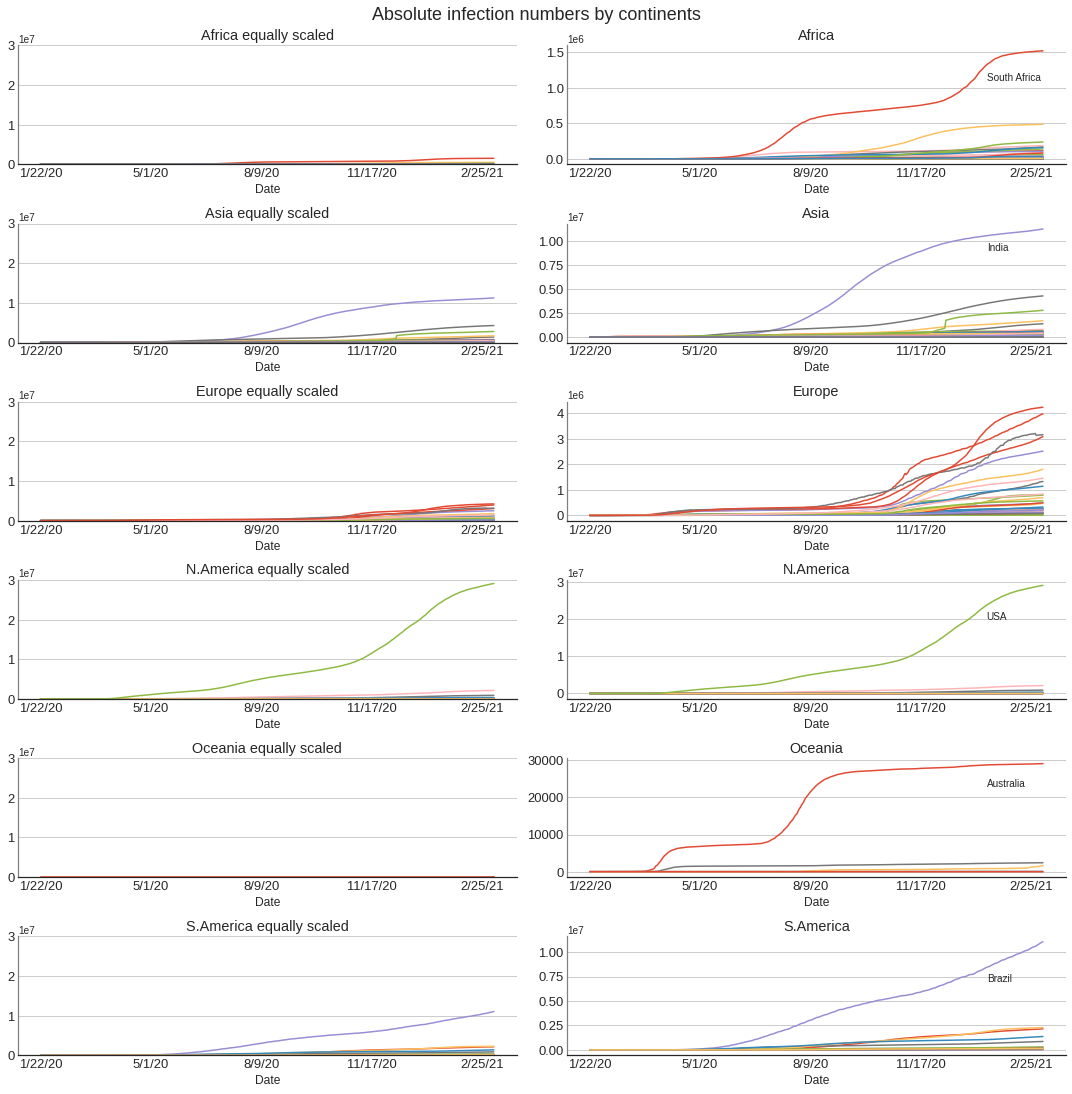

In [405]:
#Absolute infection numbers by continents
fig, ax = plt.subplots(6,2, figsize=(15,15))
n = 0

for i, v in zip(continents, continents_name):

    large['infected'][i].plot(ax=ax[n,1], title=v, fontsize=13)
    large['infected'][i].plot(ax=ax[n,0], title=v + ' equally scaled', fontsize=13)
    ax[n,0].set_ylim((0,30000000))
    ax[n,1].legend([])
    ax[n,0].legend([])
    n+=1
    
for a in ax.flat:
    a.grid(True, color='grey', alpha=0.5, axis='y')
    a.spines['top'].set_visible(False) 
    a.spines['right'].set_visible(False) 
    a.spines['left'].set_color('gray') 

ax[0,1].text(s='South Africa', x=360,y=1100000)
ax[1,1].text(s='India', x=360,y=9000000)
ax[3,1].text(s='USA', x=360,y=20000000)
ax[4,1].text(s='Australia', x=360,y=23000)
ax[5,1].text(s='Brazil', x=360,y=7000000)
                 
plt.tight_layout()
plt.suptitle('Absolute infection numbers by continents', fontsize=18, y= 1.01)

plt.savefig('pic/infection_absolute.png', dpi=160, bbox_inches='tight')
plt.show()

In [95]:
# Top infected countries by continent
top_inf_abs = pd.DataFrame()
for i, n in zip(continents, continents_name):
    thr = large['infected'][i][-1:].T.describe(percentiles=(.05,.98)).iloc[6,:].values[0]
    tops = large['infected'][i][-1:].T.loc[large['infected'][i][-1:].T.values > thr]
    tops['Continent'] = n
    top_inf_abs = top_inf_abs.append(tops)

In [96]:
top_inf_abs

Date,3/8/21,Continent
Country,,
South Africa,1521706,Africa
India,11244786,Asia
United Kingdom,4235989,Europe
US,29108096,N.America
Australia,29061,Oceania
Brazil,11051665,S.America


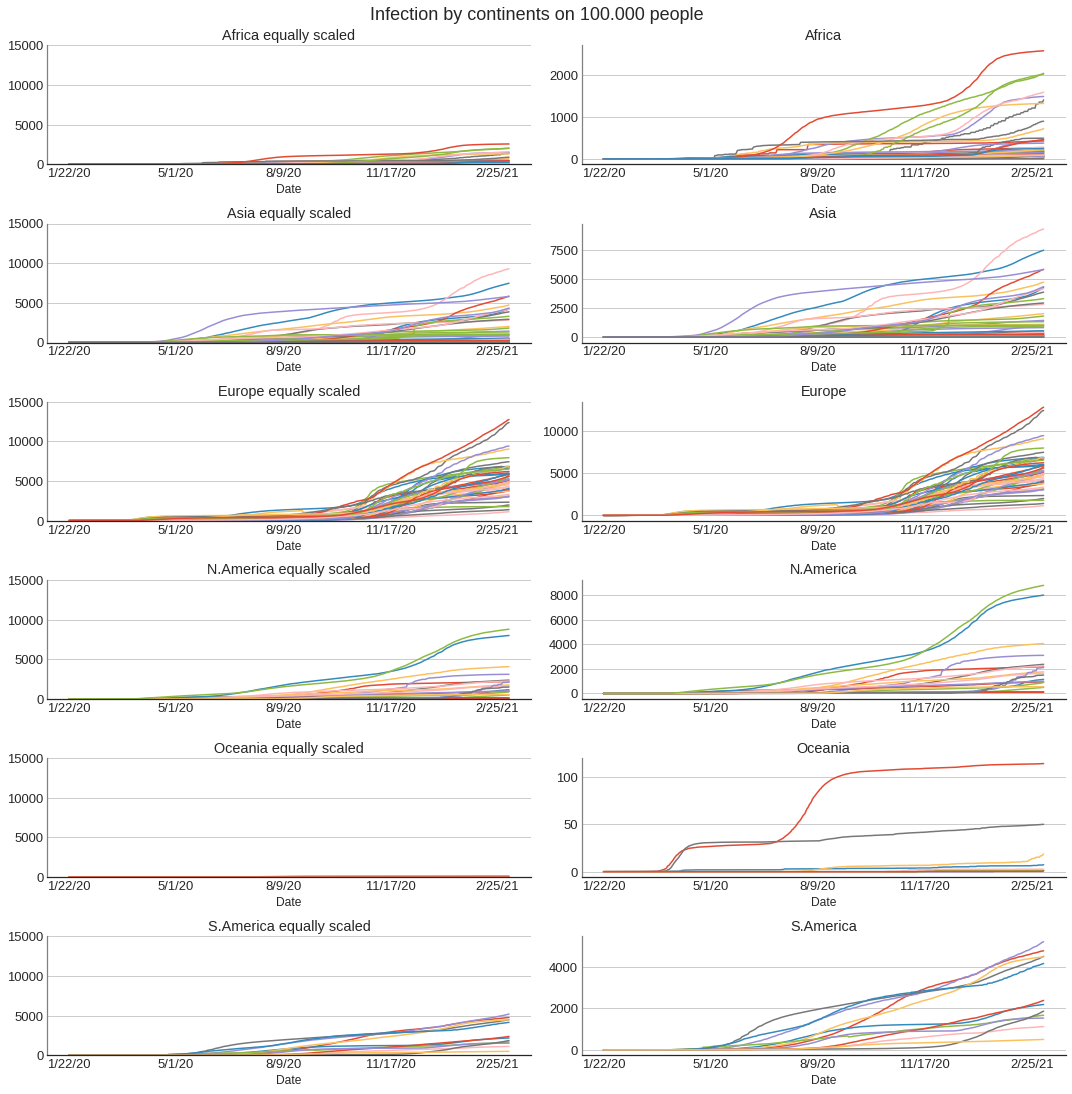

In [402]:
#Infection by continents on 100.000 people
fig, ax = plt.subplots(6,2, figsize=(15,15))
n = 0

for i, v in zip(continents, continents_name):
    
    norm['infected'][i].plot(ax=ax[n,1], title=v, fontsize= 13)
    norm['infected'][i].plot(ax=ax[n,0], title=v + ' equally scaled', fontsize= 13)
    ax[n,0].set_ylim((0,15000))
    ax[n,0].legend([])
    ax[n,1].legend([])
    n+=1
    
for a in ax.flat:
    a.grid(True, color='grey', alpha=0.5, axis='y')
    a.spines['top'].set_visible(False) 
    a.spines['right'].set_visible(False) 
    a.spines['left'].set_color('gray') 

    
plt.tight_layout()
plt.suptitle('Infection by continents on 100.000 people', fontsize=18, y= 1.01)
plt.savefig('pic/infection_normalised.png', bbox_inches='tight', dpi=160)
plt.show()

In [231]:
# countries above avg 
norm['infected'].loc[:, norm['infected'].iloc[-1,:].values/1000 > fluprev][-1:]/1000    

Country,Czechia,Israel,Luxembourg,Montenegro,Slovenia
Date,,,,,
3/8/21,12.37551,9.301747,9.054152,12.767926,9.412402


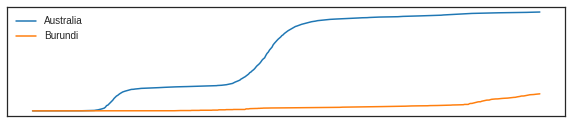

In [97]:
# graph type demonstration
style.use('seaborn-white')
fig = plt.figure(figsize=(10,2)) 
plt.plot(norm['infected'][['Australia', 'Burundi']])
plt.xticks('')
plt.yticks([])
plt.legend(['Australia', 'Burundi'], loc=2)
plt.savefig('pic/curvetypes.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
#px.line(norm['infected'][africa])

In [ ]:
#px.line(large['infected'][europe])
#px.line(large['dead'][europe])

In [ ]:
#px.line(norm['infected'][europe])
#px.line(norm['dead'][europe])

In [98]:
# calculate countries percentege with cutoff 3%. USA flu 3-11%
a = norm['infected'][-1:] > cutoff
high = [c for i, c in zip(a.values[0], a.columns) if i == True ]
low = [c for i, c in zip(a.values[0], a.columns) if i != True ]

lowratio = len(low)*100/(len(high)+len(low))
print('How much the world infected?')
print('''Higher 2000/100k: {}\nLower 2000/100k: {}\n\
---------------------- \n\
Ratio percentige: {x:.0f}% \n
{x:.0f}% of the world's countries has lower then 2% of the population got infected'''.format(len(high),len(low),x=lowratio))

How much the world infected?
Higher 2000/100k: 57
Lower 2000/100k: 124
---------------------- 
Ratio percentige: 69% 

69% of the world's countries has lower then 2% of the population got infected


In [481]:
# Create a global distribution violin plot
#take the last date
violin = norm['infected'].T.reset_index().iloc[:,[0,-1]]

In [482]:
for i,n in zip(continents, continents_name):
    violin.loc[violin['Country'].isin(i),'Continent'] = n

violin.rename(mapper={violin.columns[-2]: 'value'}, axis=1, inplace=True)

Amount of countries in certain % level.
 Red line: 3% population, Green line: world average (1.5%)


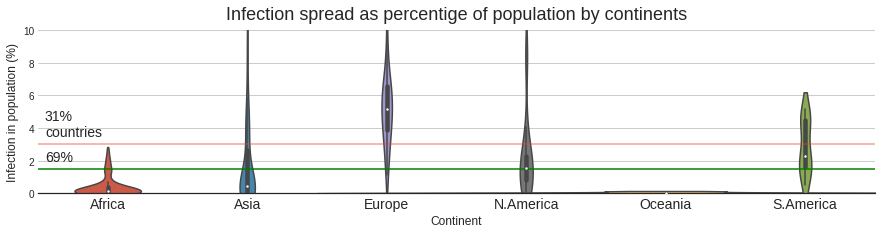

In [485]:
world_average = violin.loc[violin['Country'] == 'World', 'value'].values/1000
print('Amount of countries in certain % level.\n \
Red line: {}% population, Green line: world average ({:.1f}%)'.format(cutoffnorm,world_average[0]))
fig, ax = plt.subplots(1,1,figsize=(15,3))
sns.violinplot(x=violin.Continent.dropna().sort_values(), y=violin.iloc[:,-2]/1000, width=5, cut=1, ax= ax)
ax.axhline(cutoffnorm, alpha=0.5)
ax.axhline(world_average, color='green')
ax.set(ylabel='Infection in population (%)',
      ylim= (0,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_color('grey')
ax.set_xticklabels(sorted(set(violin.Continent.dropna())),fontsize=14)

plt.title('Infection spread as percentige of population by continents', y=1.03, fontsize= 18)
plt.annotate(text= '{:.0f}%\ncountries'.format(100-lowratio), xy=(-0.45,3.5),fontsize=14)
plt.annotate(text= '{:.0f}%'.format(lowratio), xy=(-0.45,2.0), fontsize=14)
plt.grid(True, color='grey', alpha=0.5,axis = 'y')

plt.savefig('pic/inf_norm_violin.png', dpi=160, bbox_inches='tight')
plt.show()

In [102]:
#data for geomap
geodf = large['infected'][-1:].T.copy()
geodf.reset_index(inplace=True)
geodf['iso'] = geodf['Country'].map(isocodes)
geodf.dropna(inplace=True)
geodfnorm = norm['infected'][-1:].T.copy()
geodfnorm.reset_index(inplace=True)
geodfnorm['iso'] = geodfnorm['Country'].map(isocodes)
geodfnorm['iso'].dropna(inplace=True)
geodfnorm['3/8/21'] = geodfnorm['3/8/21']/1000

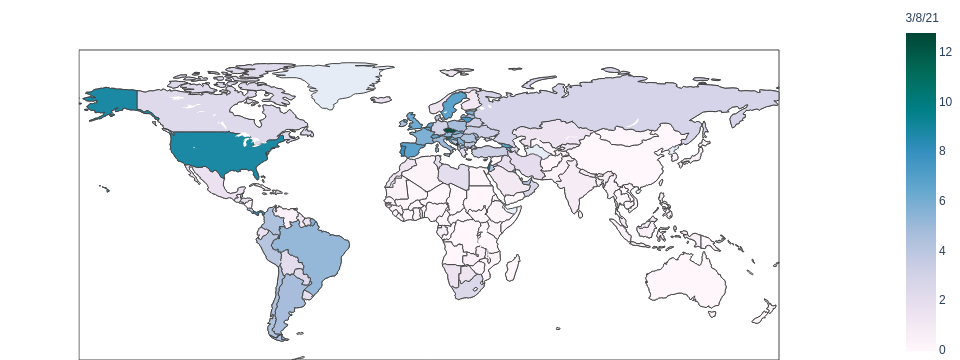

In [262]:
##### absolute
import plotly.express as px

fig = px.choropleth(geodfnorm, locations="iso",
                    color="3/8/21", 
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.PuBuGn,
                    center=dict(lat=25,lon=10),
                   width=800, height=350
                    
                   )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.write_image("pic/geo_norm.png")
fig.show()

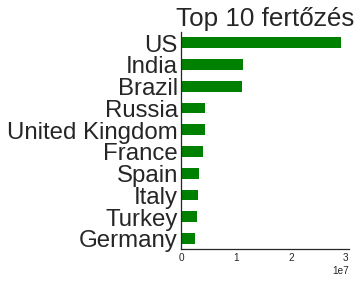

In [389]:
# 10 most infected countries
top10 = large['infected'].iloc[-1:,:].T.sort_values('3/8/21', ascending= False).head(11)

fig, ax = plt.subplots(1,1, figsize=(3,4))

top10[1:].plot(kind='barh', color='g', ax=ax)
#ax.set_title('Top 10 infections', fontsize=26)
ax.set_title('Top 10 fertőzés', fontsize=26)
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_yticklabels(top10[1:].index, fontsize=24)
plt.legend('')

fig.savefig('pic/hu/top10_inf.png', dpi=160, bbox_inches='tight')
plt.show()

In [141]:
# top 3 ratio from world infection
top3sum = large['infected'].loc[:,large['infected'].columns.isin(['US','India','Brazil'])][-1:].sum(axis=1).values[0]
top10sum = sum(top10[1:].values)[0]
print('World infection: {}'.format(worldinf))
print('Sum Top 3 infections: {}'.format(top3sum))
print('Sum Top 10 infections {}'.format(top10sum))
print('Top 3 ration of world: {}'.format(top3sum*100/worldinf))
print('Top 10 ration of world: {}'.format(top10sum*100/worldinf))

World infection: 117211513
Sum Top 3 infections: 51404547
Sum Top 10 infections 75444310
Top 3 ration of world: 43.85622681962991
Top 10 ration of world: 64.36595524536911


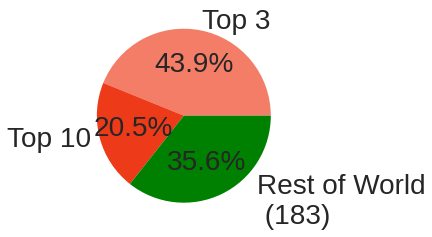

In [396]:
ax = plt.subplot(111)
pd.Series([top3sum,top10sum-top3sum,worldinf-top10sum],\
          index=['Top 3', 'Top 10', '    Rest of World\n     (183)']).plot(kind='pie',
                                                           
                                                        fontsize= 28,
                                                        autopct='%1.1f%%',
                                                        colors=[(0.92,0.15,0,0.6),((0.92,0.15,0,0.9)), 'green'],
                                                        ax= ax)
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('pic/top_pie.png', dpi=160, bbox_inches='tight')

plt.show()

In [151]:
#add world to continents
violin.loc[violin['Country'] == 'World', 'Continent'] = 'World'

In [153]:
# statistics of infections
mean = violin.groupby('Continent')['value'].describe(percentiles=[0.1,0.9])
mean.fillna(0, inplace=True)
mean = mean.apply(lambda x: x.astype(int))
print('Continental statistics of infections')
mean

Continental statistics of infections


,count,mean,std,min,10%,50%,90%,max
Continent,,,,,,,,
Africa,51,398,599,0,40,151,1399,2565
Asia,46,1614,2245,0,6,454,4536,9301
Europe,43,5365,2482,1128,2469,5174,7845,12767
N.America,20,2158,2371,97,129,1575,4450,8793
Oceania,8,24,39,0,0,4,69,113
S.America,12,2862,1639,502,1161,2281,4740,5199
World,1,1503,0,1503,1503,1503,1503,1503


In [154]:
print('Continental distrubution of countries above {}% of population infection'.format(cutoffnorm))
a = violin.loc[violin['value'] > cutoff, 'Continent'].value_counts(normalize= True)*100
b = violin.loc[violin['value'] > cutoff, 'Continent'].value_counts()
c = pd.concat([a,b], axis =1)
c.columns = ['Precent of above 3%','Count']
c['Percent of the Continent'] = c['Count']/mean['count']*100
c = c.apply(lambda x: x.astype(int))
c

Continental distrubution of countries above 3% of population infection


,Precent of above 3%,Count,Percent of the Continent
Europe,66,38,88
Asia,17,10,21
S.America,8,5,41
N.America,7,4,20


In [155]:
# create the infection-dead-rank graph
#create labels for infection side
violinrank= violin.sort_values('value', ascending=False).reset_index(drop=True)
violinrank['inf rank'] = violinrank.index
violinrank['Region'] =violinrank.apply(lambda x: '{}, {}, {}'.format(x[3]+1,x[0],x[2]), axis=1)

In [156]:
# create normalised dead last date df
d = norm['dead'][-1:].T.reset_index()
d.sort_values(d.columns[-1], ascending= False, inplace=True)
d.reset_index(drop=True, inplace=True)
d.reset_index(inplace=True)
d.rename(mapper={d.columns[-1]: 'dead', 'index': 'dead rank'}, axis=1, inplace=True)

In [157]:
#create labels for dead side
violinrank = pd.merge(violinrank,d, on='Country', how='left')
violinrank['Region dead'] = violinrank.apply(lambda x: '{} {}, {}'.format(x[5]+1,x[0],x[2]), axis=1)

In [158]:
# create links between infection-dead ranks
violinrank['links'] = violinrank.apply(lambda x: (x[3],x[5]), axis=1)

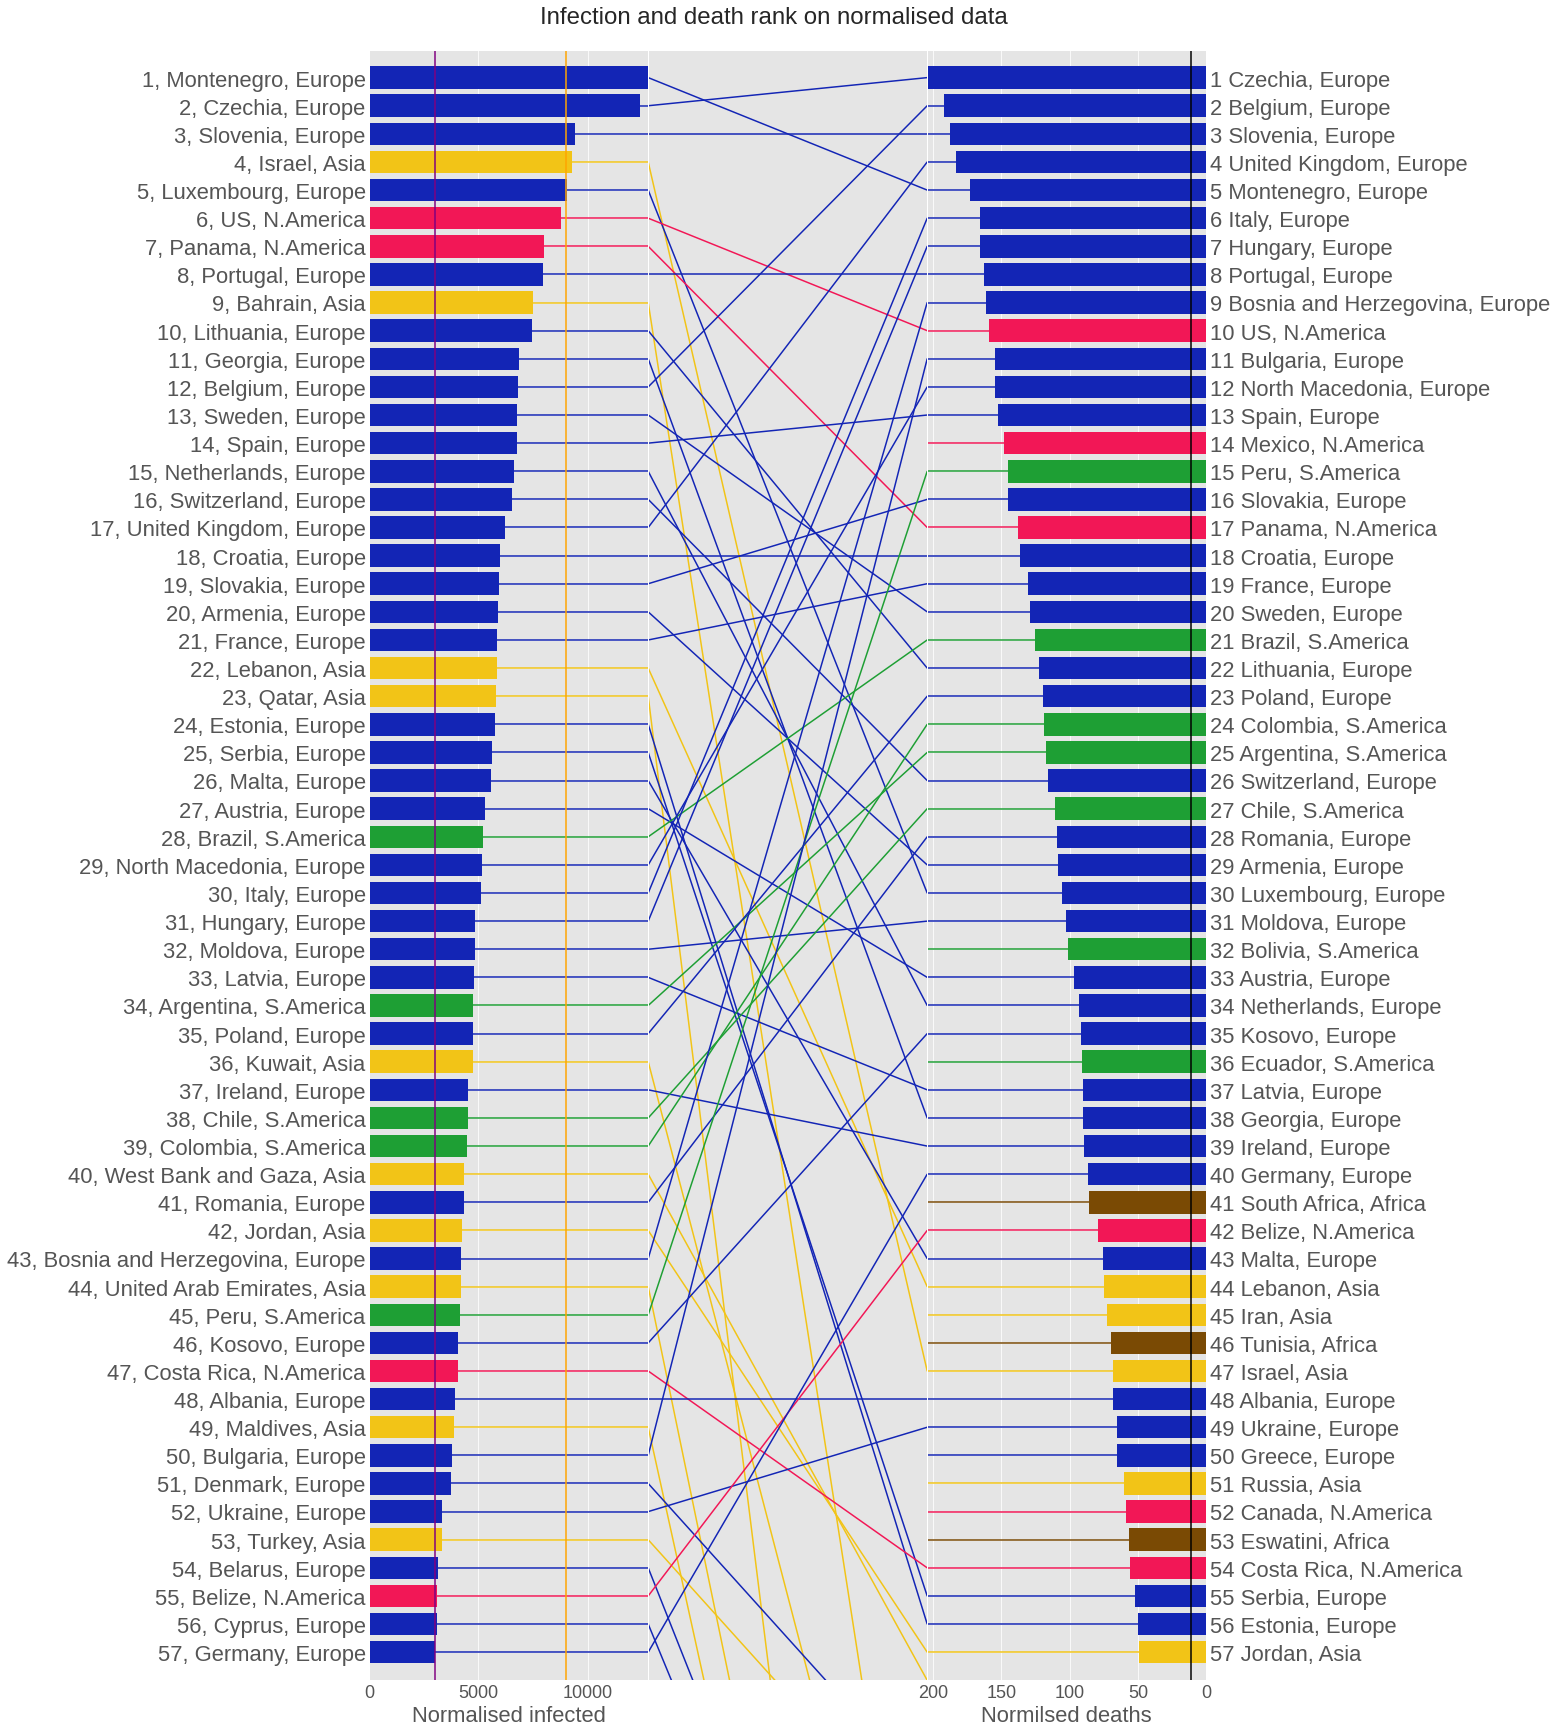

In [422]:
N = violinrank.loc[violinrank['value'] > cutoff].shape[0]
cmap = {'Europe': '#1325b5', 'N.America':'#f21756',
                                     'Asia':'#f2c417', 'Africa':'#7a4a04',
                                     'Oceania': '#3793b4','S.America':'#1e9f34', 'World': '#051107'}
colormap = violinrank.Continent.map({'Europe': '#1325b5', 'N.America':'#f21756',
                                     'Asia':'#f2c417', 'Africa':'#7a4a04',
                                     'Oceania': '#3793b4','S.America':'#1e9f34', 'World': '#051107'})
maxinf = violinrank.value.max()
maxdead = violinrank.dead.max()

style.use('ggplot')
fig, ax = plt.subplots(1,3,figsize=(15,30))
plt.subplots_adjust(wspace=-0)


for n,i in violinrank[:N].iterrows():
    ax[0].plot([i['value'],maxinf], [i['inf rank'],i['inf rank']], c=colormap[n])
ax[0].barh(y= violinrank.loc[violinrank['value'] > cutoff, 'Region'], \
           width=violinrank.loc[violinrank['value'] > cutoff, 'value'], \
            color=colormap)

for n,i in violinrank.sort_values('dead rank').iloc[:N,:].iterrows():
    ax[2].plot([i['dead'],maxdead], [i['dead rank'], i['dead rank']], c=colormap[n])
ax[2].barh(y=violinrank.sort_values('dead rank').iloc[:N,:]['Region dead'],\
           width=violinrank.sort_values('dead rank').iloc[:N,:]['dead'],\
          color=violinrank.sort_values('dead rank').iloc[:N,:]['Continent'].map(cmap))

for n,i in violinrank.loc[violinrank['value'] > cutoff, :].iterrows():
    ax[1].plot(i['links'], c=i.map(cmap)['Continent'] )
    
ax[0].axvline(cutoff, color='purple') #min US flu
ax[0].axvline(fluprev*1000, color='orange') # avg US flu
ax[2].axvline(11, color='black')

ax[0].set_yticklabels(violinrank['Region'][:N], size= 22)
ax[0].set(ylim=(-1,N), xlim=(0,maxinf),
         ylabel='')
ax[0].set_xlabel('Normalised infected', fontsize=22)
ax[0].invert_yaxis()
ax[0].tick_params(axis='x', labelsize=18)
ax[1].set(yticks = [],
          xticks= [],
          ylim=(-1,N), xlim=(0,1),
         )
ax[1].grid(False)
ax[1].invert_yaxis()
          
ax[2].tick_params(axis='x', labelsize=18)
ax[2].yaxis.set_ticks_position('right')
ax[2].yaxis.set_label_position('right')
ax[2].set(ylim = (-1,N), xlim=(0,maxdead))
ax[2].set_xlabel('Normilsed deaths', size=22)
ax[2].set_yticklabels(violinrank.sort_values('dead rank').iloc[:N]['Region dead'],size=22)
ax[2].invert_xaxis()
ax[2].invert_yaxis()

plt.suptitle('Infection and death rank on normalised data', y=0.9, fontsize=24)

plt.savefig('pic/infection-dead.png', dpi=160, bbox_inches='tight')
plt.show()

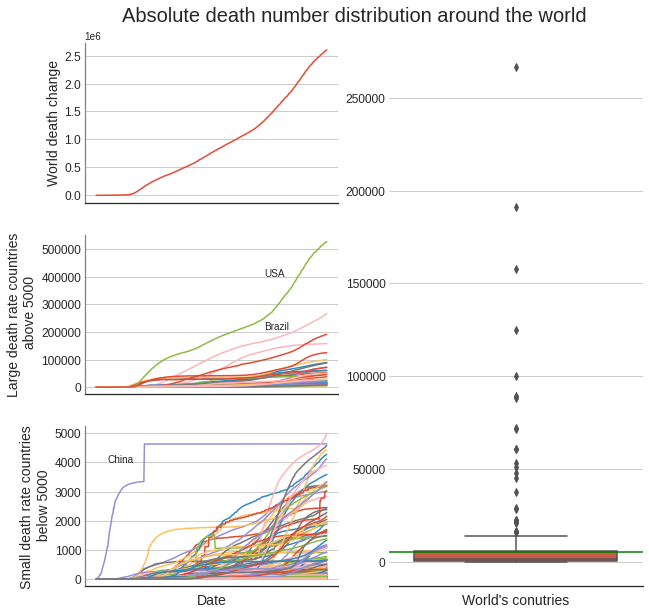

In [476]:
# absolute death
deadthr = 5000
small = large['dead'].loc[:,large['dead'].iloc[-1,:] < deadthr]
larges = large['dead'].loc[:,large['dead'].iloc[-1,:] >= deadthr]
worlddead = larges[['World']]
larges.drop('World', axis =1, inplace= True)  # outlayers drop
box = large['dead'].drop(['World','US'], axis=1)[-1:] #outlayers drop

style.use('seaborn-white')
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid(shape=(3,2),loc=(0,0))
ax1 = plt.subplot2grid(shape=(3,2),loc=(1,0))
ax2 = plt.subplot2grid(shape=(3,2),loc=(2,0))
ax3 = plt.subplot2grid(shape=(3,2),loc=(0,1), rowspan=3)
ax0.plot(worlddead.index, worlddead)
ax1.plot(larges.index, larges)
ax2.plot(small.index, small)
sns.boxplot(y=box.values, ax= ax3)
ax3.axhline(deadthr, color= 'green')

ax1.text(x=300, y=400000, s='USA')
ax1.text(x=300, y=210000, s='Brazil' )
ax2.text(x=20, y=4000, s='China')
for a in [ax0,ax1,ax2,ax3]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_color('grey')
    a.grid(True, axis='y', color='grey', alpha=0.5)
    a.set(xticklabels = [])
    a.tick_params(axis='y', labelsize=12)

ax3.spines['left'].set_visible(False)

fsize = 14
ax0.set_ylabel('World death change', fontsize= fsize)
ax1.set_ylabel('Large death rate countries\n above {}'.format(deadthr), fontsize= fsize)
ax2.set_ylabel('Small death rate countries\n below {}'.format(deadthr), fontsize= fsize)
ax2.set_xlabel('Date', fontsize= fsize)
ax3.set_xlabel('World\'s conutries', fontsize= fsize)

plt.suptitle('Absolute death number distribution around the world', y=0.93, fontsize=20) 

plt.savefig('pic/death_world.png', dpi=160, bbox_inches='tight')
plt.show()

In [198]:
#initiate death statistics
deaddic={'Counties under 5000': {'Count': small.shape[1],'Percentage': round(small.shape[1]*100/large['dead'].shape[1],0)},
        'Countries over 5000': {'Count': larges.shape[1],'Percentage': round(larges.shape[1]*100/large['dead'].shape[1],0)}}
pd.DataFrame(deaddic).T

,Count,Percentage
Counties under 5000,130.0,72.0
Countries over 5000,50.0,28.0


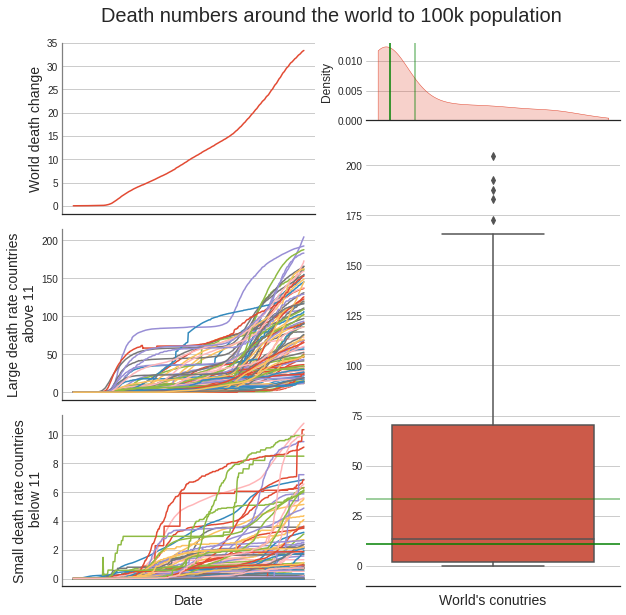

In [437]:
# normalised death
deadthr = fludead100k # corresponds to US flu average death rate 11/100k
Nsmall = norm['dead'].loc[:,norm['dead'].iloc[-1,:] < deadthr]
Nlarges = norm['dead'].loc[:,norm['dead'].iloc[-1,:] >= deadthr]
worlddead = Nlarges[['World']]
Nlarges.drop('World', axis =1, inplace= True)
Nbox = norm['dead'].drop(['World'], axis =1)[-1:]

style.use('seaborn-white')
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid(shape=(6,2),loc=(0,0), rowspan=2)
ax1 = plt.subplot2grid(shape=(6,2),loc=(2,0), rowspan=2)
ax2 = plt.subplot2grid(shape=(6,2),loc=(4,0), rowspan=2)
ax3 = plt.subplot2grid(shape=(6,2),loc=(0,1))
ax4 = plt.subplot2grid(shape=(6,2),loc=(1,1), rowspan=5)

ax0.plot(worlddead.index, worlddead)
ax1.plot(Nlarges.index, Nlarges)
ax2.plot(Nsmall.index, Nsmall)

sns.kdeplot(Nbox.values[0], fill=True,cut=0,ax=ax3)
ax3.axvline(deadthr, color ='green')  # flu
ax3.axvline(worlddead[-1:].values[0], color= 'green', alpha=0.5) # world average

sns.boxplot(y=Nbox.values, ax= ax4)
ax4.axhline(deadthr, color= 'green') #flu
ax4.axhline(worlddead[-1:].values[0], color= 'green', alpha=0.5) # world average

for a in [ax0,ax1,ax2,ax3,ax4]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_color('grey')
    a.grid(True, axis='y', color='grey', alpha=0.5)
    a.set(xticklabels = [])

ax3.spines['left'].set_visible(False)
ax4.spines['left'].set_visible(False)

fsize = 14
ax0.set_ylabel('World death change', fontsize= fsize)
ax1.set_ylabel('Large death rate countries\n above {}'.format(deadthr), fontsize= fsize)
ax2.set_ylabel('Small death rate countries\n below {}'.format(deadthr), fontsize= fsize)
ax2.set_xlabel('Date', fontsize= fsize)
ax4.set_xlabel('World\'s conutries', fontsize= fsize)

plt.suptitle('Death numbers around the world to 100k population', y=0.93, fontsize=20)

plt.savefig('pic/death_world_norm.png', dpi=160,bbox_inches = 'tight')
plt.show()

In [199]:
#continue death statistics
deaddic.update({'Countries under flu':{'Count':Nsmall.shape[1], 'Percentage': round(Nsmall.shape[1]*100/norm['dead'].shape[1],0)},
'Countries above flu':{'Count':Nlarges.shape[1], 'Percentage': round(Nlarges.shape[1]*100/norm['dead'].shape[1],0)},
'Countries bellow World avg:':{'Count':Nbox.loc[:, Nbox.iloc[-1] < worlddead[-1:].values[0][0]].shape[1],
                               'Percentage': round(Nbox.loc[:, Nbox.iloc[-1] < worlddead[-1:].values[0][0]].shape[1]*100/182,0) },
               })

In [200]:
print('Death statistics')
pd.DataFrame(deaddic, dtype=int).T

Death statistics


,Count,Percentage
Counties under 5000,130,72
Countries over 5000,50,28
Countries under flu,84,46
Countries above flu,96,53
Countries bellow World avg:,115,63


### overall fatality change

In [173]:
springtime = '5/21/20'
large['fatality'] = large['dead']*100 /large['infected']
large['fatality'] = large['fatality'].applymap(lambda x: np.NaN if x == np.inf else x)

In [ ]:
#px.line(large['fatality'])

In [170]:
#px.line(large['fatality'][asia].dropna())

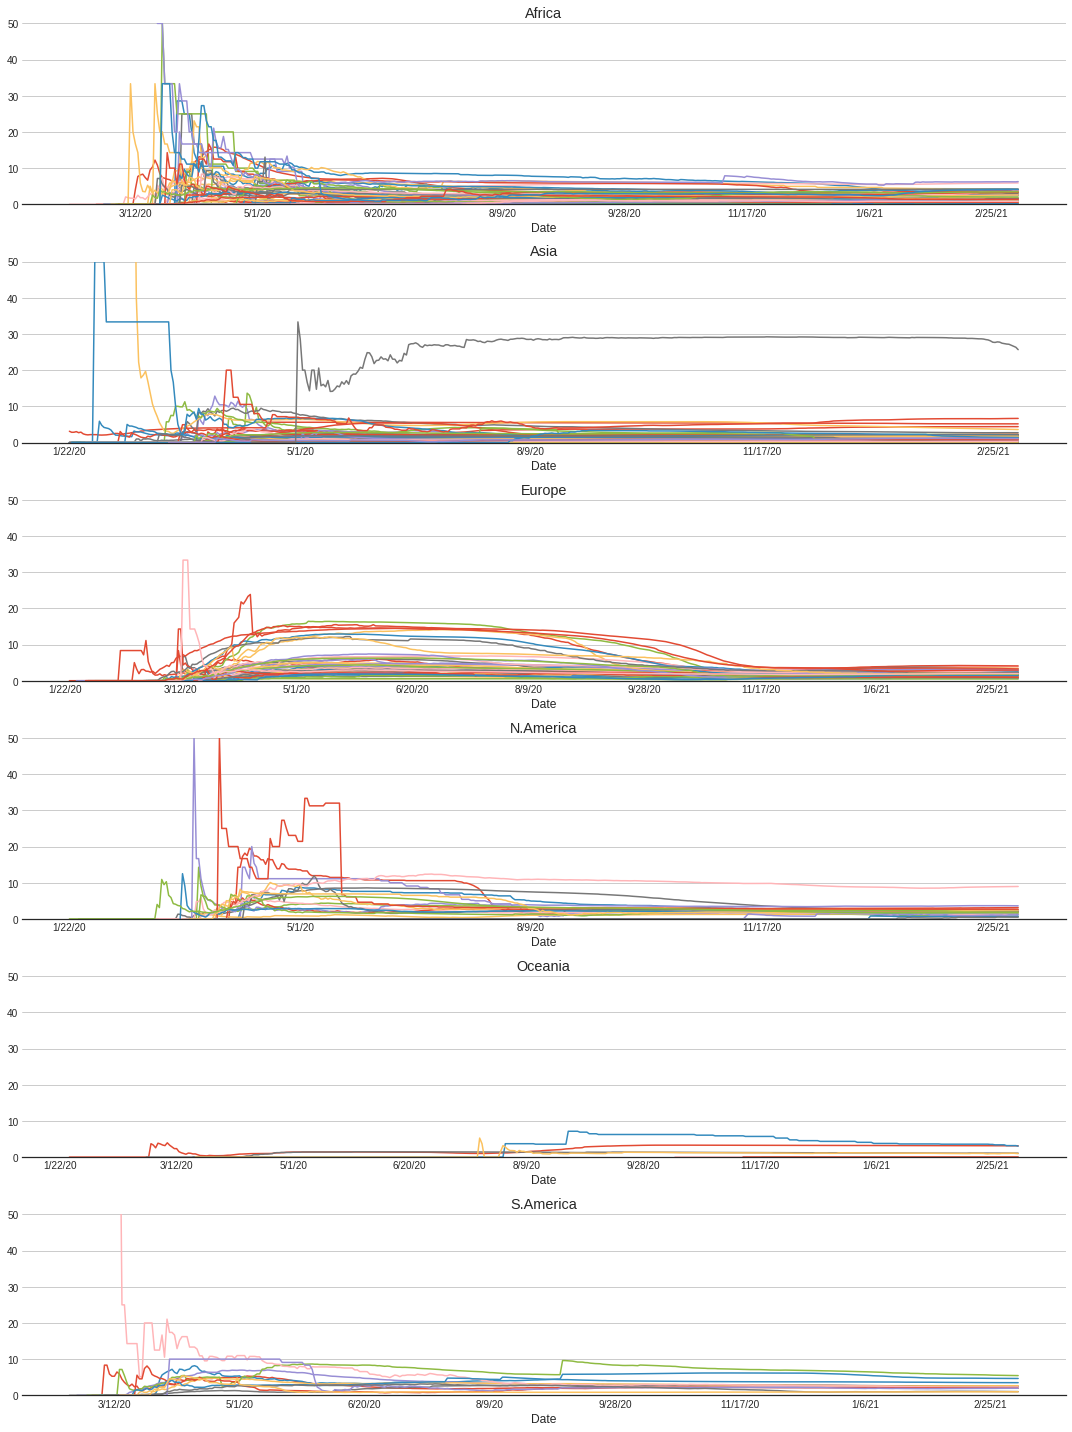

In [171]:
#continents fatality change
fig,ax = plt.subplots(len(continents),1,figsize=(15,20))
for n,i in enumerate(continents):
    large['fatality'][i].plot(ax= ax[n])
    ax[n].set(title='{}'.format(continents_name[n]),
             ylim=(0,50))

for a in ax.flat[:-1]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.grid(True, axis='y', color='grey', alpha=0.5)
    a.legend([])
                     
ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].grid(True, axis='y', color='grey', alpha=0.5)
ax[-1].legend([])

plt.tight_layout()

plt.savefig('pic/fatality_continet.png', dpi=100, bbox_inches='tight')
plt.show()

In [174]:
# europe fatality: spring vs recent
b = large['infected'][europe].loc[springtime,:].sum()
c = large['dead'][europe].loc[springtime,:].sum()
eufat_spring = c/b*100
b = large['infected'][europe].loc['3/8/21',:].sum()
c = large['dead'][europe].loc['3/8/21',:].sum()
eufat_recent = c/b*100

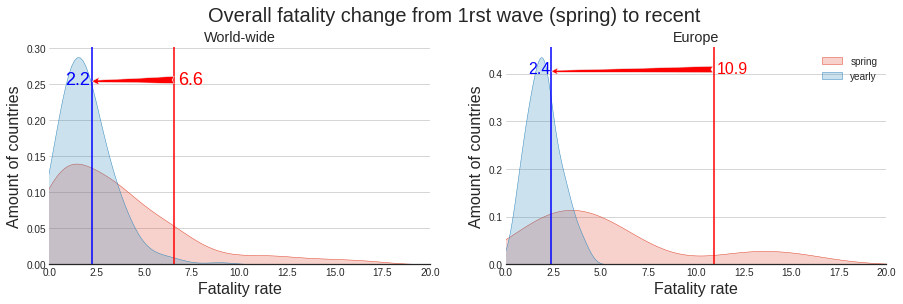

In [463]:
# average fatalitiy change between spring and recent, world, europe

fig, ax = plt.subplots(1,2, figsize=(15,4))

#world
sns.kdeplot(large['fatality'].loc[springtime,:] , ax=ax[0], fill=True, label='spring')
sns.kdeplot(large['fatality'].iloc[-1,:], ax=ax[0], fill=True, label='yearly')
ax[0].axvline(large['fatality'].loc[springtime,'World'], color='red')
ax[0].axvline(large['fatality'].iloc[-1,:]['World'], color='blue')

#Europe
sns.kdeplot(large['fatality'][europe].loc[springtime,:] , ax=ax[1], fill=True, label='spring')
sns.kdeplot(large['fatality'][europe].iloc[-1,:], ax=ax[1], fill=True, label='yearly')
ax[1].axvline(eufat_spring, color='red')
ax[1].axvline(eufat_recent, color='blue')

ax[0].set(title='World-wide')
ax[1].set(title='Europe')

ax[0].annotate(text=round(large['fatality'].loc[springtime,'World'],1), color='red', fontsize=18,
               xy=(2.15,.254), 
               xytext=(large['fatality'].loc[springtime,'World']+0.2,.25), 
               arrowprops={'arrowstyle':'fancy','facecolor':'red'})

ax[0].annotate(text=round(large['fatality'].iloc[-1,:]['World'],1), color='blue', fontsize=18,
               xy=(large['fatality'].iloc[-1,:]['World']-1.4,.25), 
               )

ax[1].annotate(text= round(eufat_spring,1), color='red', fontsize=16,
            xy=(2.3, 0.405),
            xytext=(eufat_spring+0.15, 0.4),
            arrowprops=dict(arrowstyle='fancy', facecolor='red'))
ax[1].annotate(text=round(eufat_recent,1), color='blue', fontsize=16,
            xy=(eufat_recent-1.2,0.4))


for a in ax.flatten():
    a.axes.spines['top'].set_visible(False)
    a.axes.spines['right'].set_visible(False)
    a.axes.spines['left'].set_visible(False)
    a.grid(axis='y')
    a.set(xlim=(0,20))
    
    a.set_xlabel('Fatality rate', fontsize=16)
    a.set_ylabel('Amount of countries', fontsize=16)

plt.legend()
plt.suptitle('Overall fatality change from 1rst wave (spring) to recent', y= 1.02, size= 20)

plt.savefig('pic/europe_fatality_change.png', dpi =160, bbox_inches='tight')
plt.show()

In [176]:
#sping vs authumn fatality sectional

In [177]:
#removing outlayers: negative or 10x mean
sectiondata= pd.DataFrame()
for c in norm['inf_day'].columns:
    thr = norm['inf_day'][c].mean()*10
    sectiondata[c] = norm['inf_day'][c].map(lambda x: 0 if (x > thr) or x< 0 else x)

sectiondatadead = pd.DataFrame()
for c in norm['dead_day'].columns:
    thr = norm['dead_day'][c].mean()*10
    sectiondatadead[c] = norm['dead_day'][c].map(lambda x: 0 if (x > thr) or x< 0 else x)

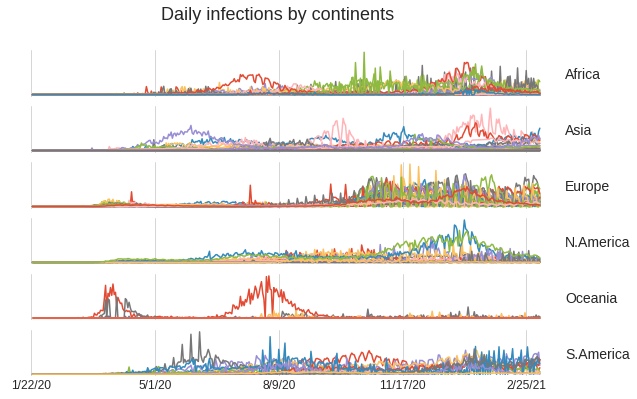

In [478]:
# daily infections
fig, ax = plt.subplots(len(continents),1,figsize=(10,6),sharex=True)
for n,a in enumerate(ax.flat):
    sectiondata[continents[n]].plot(ax=a)
    a.set_title(continents_name[n], y=0.25, x= 1.0, ha='left', fontsize=14)
    a.legend('')
    a.axes.spines['top'].set_visible(False)
    a.axes.spines['right'].set_visible(False)
    a.axes.spines['bottom'].set_visible(False)
    a.axes.spines['left'].set_visible(False)
    a.set(yticklabels='')
    a.tick_params(axis='x', labelsize=12)
    a.grid(True,axis='x')
             
plt.suptitle('Daily infections by continents', fontsize=18)

plt.savefig('pic/daily_inf.png', dpt= 160, bbox_inches='tight')
plt.show()

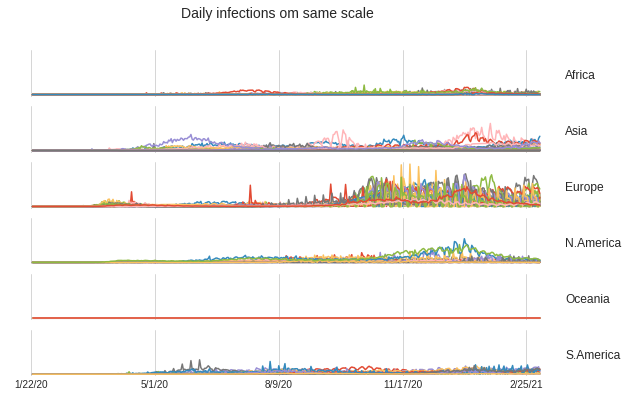

In [179]:
# daily infections on scaled graph
fig, ax = plt.subplots(len(continents),1,figsize=(10,6),sharex=True,sharey=True)
for n,a in enumerate(ax.flat):
    sectiondata[continents[n]].plot(ax=a)
    a.set_title(continents_name[n], y=0.25, x= 1.0, ha='left', fontsize=12)
    a.legend('')
    a.axes.spines['top'].set_visible(False)
    a.axes.spines['right'].set_visible(False)
    a.axes.spines['bottom'].set_visible(False)
    a.axes.spines['left'].set_visible(False)
    a.set(yticklabels='')
    a.grid(True, axis='x')
             
plt.suptitle('Daily infections om same scale', fontsize=18)

plt.savefig('pic/daily_inf_scaled.png', dpi=160)
plt.show()

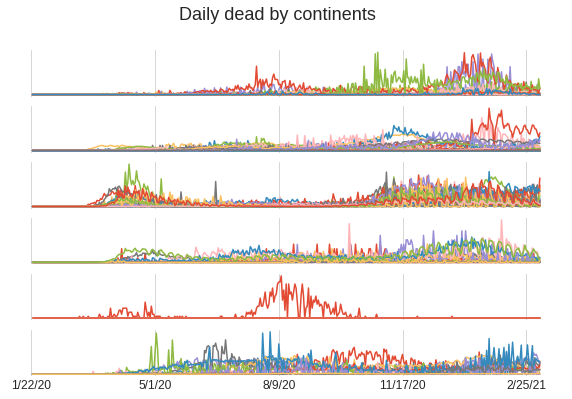

In [480]:
# daily infections
fig, ax = plt.subplots(len(continents),1,figsize=(10,6),sharex=True)
for n,a in enumerate(ax.flat):
    sectiondatadead[continents[n]].plot(ax=a)
    a.legend('')
    a.axes.spines['top'].set_visible(False)
    a.axes.spines['right'].set_visible(False)
    a.axes.spines['bottom'].set_visible(False)
    a.axes.spines['left'].set_visible(False)
    a.set(yticklabels='')
    a.grid(True,axis='x')
    a.tick_params(axis='x', labelsize=12)
             
plt.suptitle('Daily dead by continents', fontsize=18)

plt.savefig('pic/daily_dead.png', dpi=160, bbox_inches='tight')
plt.show()

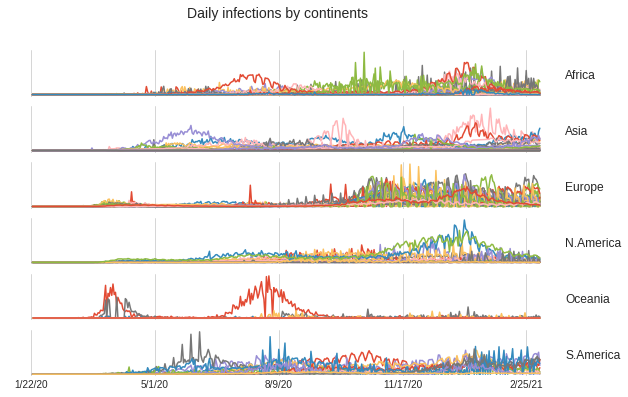

In [181]:
# daily infections
fig, ax = plt.subplots(len(continents),1,figsize=(10,6),sharex=True)
for n,a in enumerate(ax.flat):
    sectiondata[continents[n]].plot(ax=a)
    a.set_title(continents_name[n], y=0.25, x= 1.0, ha='left', fontsize=12)
    a.legend('')
    a.axes.spines['top'].set_visible(False)
    a.axes.spines['right'].set_visible(False)
    a.axes.spines['bottom'].set_visible(False)
    a.axes.spines['left'].set_visible(False)
    a.set(yticklabels='')
    a.grid(True,axis='x')
             
plt.suptitle('Daily infections by continents', fontsize=14)

plt.savefig('pic/daily_inf.png')
plt.show()

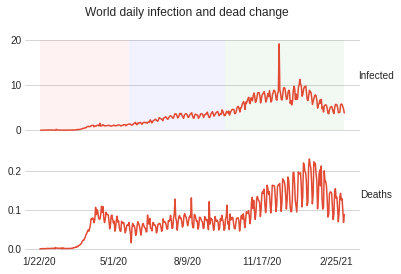

In [451]:
# World daily infection and dead change

fig, ax = plt.subplots(2,1)
#norm['inf_day']['World'].plot(ax=ax[0])
ax[0].plot(norm['inf_day']['World'].index, norm['inf_day']['World'])
norm['dead_day']['World'].plot(ax=ax[1])

for a in ax.flat:
    a.legend('')
    a.axes.spines['top'].set_visible(False)
    a.axes.spines['right'].set_visible(False)
    a.axes.spines['bottom'].set_visible(False)
    a.axes.spines['left'].set_visible(False)
    a.grid(True, axis='y')

ax[0].set(xticklabels='')
ax[0].set_title('Infected', y=0.5, x=1.05, fontsize=10)
ax[1].set_title('Deaths', y=0.5, x=1.05, fontsize=10)

ax[0].fill([norm['inf_day'].index[0],norm['inf_day'].index[0], norm['inf_day'].index[120],norm['inf_day'].index[120]],
           [0,20,20,0], 'red', alpha=0.05)

ax[0].fill([norm['inf_day'].index[120],norm['inf_day'].index[120], norm['inf_day'].index[250],norm['inf_day'].index[250]],
           [0,20,20,0], 'blue', alpha=0.05)
ax[0].fill([norm['inf_day'].index[250],norm['inf_day'].index[250], norm['inf_day'].index[-1],norm['inf_day'].index[-1]],
           [0,20,20,0], 'green', alpha=0.05)

plt.suptitle('World daily infection and dead change', fontsize=12)

plt.savefig('pic/world_inf_sections.png', dpi=160, bbox_inches='tight')
plt.show()

In [183]:
#section date borders
norm['inf_day'].index[120],norm['inf_day'].index[250]

('5/21/20', '9/28/20')

In [184]:
# section fatalities: spring, summer, authumn
springtime # see above
summertime = '9/28/20'

spring_inf = large['infected']['World'][springtime]
spring_dead = large['dead']['World'][springtime]
summer_inf = large['infected']['World'][summertime] - spring_inf
summer_dead = large['dead']['World'][summertime] - spring_dead
authumn_inf = large['infected']['World'][-1] - (spring_inf + summer_inf)
authumn_dead = large['dead']['World'][-1] - (spring_dead + summer_dead)

spring_fat = spring_dead*100/spring_inf
summer_fat = summer_dead*100/summer_inf
authumn_fat = authumn_dead*100/authumn_inf

In [340]:
sectioninf = [spring_inf,summer_inf,authumn_inf]
sectiondead = [spring_dead,summer_dead, authumn_dead]
sectionname = ['Spring', 'Summer', 'Winter']
sectionfat = [spring_fat,summer_fat,authumn_fat]
sectionfat = [round(s, 2) for s in sectionfat]

In [341]:
print(sectioninf, sectiondead, sectionfat)
large['fatality']['World'][[springtime, summertime, '3/8/21']],

[5115471, 28286639, 83809403] [336444, 666067, 1597917] [6.58, 2.35, 1.91]


(Date
 5/21/20    6.576990
 9/28/20    3.001340
 3/8/21     2.218577
 Name: World, dtype: float64,)

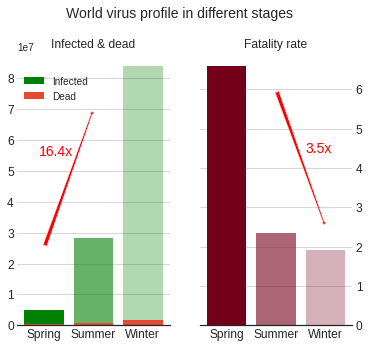

In [486]:
#World virus profile in different stages

fig = plt.figure(figsize=(6,5))
ax= fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

ax.bar(sectionname,sectioninf, color=[(0,0.5,0,1), (0,0.5,0,0.6),(0,0.5,0,0.3)], label='Infected')
ax.bar(sectionname,sectiondead, label='Dead')

ax1.bar(sectionname, sectionfat, color=[(0.46,0,0.1, 1), (0.46,0,0.1, 0.6),(0.46,0,0.1, 0.3)])

ax.annotate(text='', xytext=(0,25000000), xy=(1,70000000), arrowprops=dict(arrowstyle='fancy', facecolor='red'))
ax1.annotate(text='', xy=(2,2.5), xytext=(1,6), arrowprops=dict(arrowstyle='fancy', facecolor='red'))
ax.text(x=-0.1,y=55000000, s='16.4x', fontsize=14, color='red')
ax1.text(x=1.6, y=4.4, s='3.5x', fontsize=14, color='red')

for a in [ax,ax1]:
    a.axes.spines['top'].set_visible(False)
    a.axes.spines['right'].set_visible(False)
    #ax.axes.spines['bottom'].set_visible(False)
    a.axes.spines['left'].set_visible(False)
    a.grid(True, axis='y')
    a.tick_params(axis='x', labelsize= 12)
    a.tick_params(axis='y', labelsize=12)
ax.set_title('Infected & dead', fontsize=12)
ax.legend(loc=(0.02, 0.81))

ax1.set_title('Fatality rate', fontsize=12)
ax1.yaxis.set_ticks_position('right')
ax1.yaxis.set_label_position('right')

plt.suptitle('World virus profile in different stages', y=1.01, fontsize=14)

plt.savefig('pic/world_fatality_bar.png', dpi=160, bbox_inches='tight')
plt.show()

In [362]:
print('spring, summer, winter')
sectionfat

spring, summer, winter


[6.58, 2.35, 1.91]

In [334]:
#rise of infections from season to season
print('summer/spring \t winter/summer \t winter/spring')
sectioninf[1]/sectioninf[0],sectioninf[2]/sectioninf[1], sectioninf[2]/sectioninf[0]

summer/spring 	 winter/summer 	 winter/spring


(5.5296255222637365, 2.9628618302796594, 16.383516395655455)

In [335]:
# dead rise from seaction to section
print('summer/spring \t winter/summer \t winter/spring')
sectiondead[1]/sectiondead[0],sectiondead[2]/sectiondead[1], sectiondead[2]/sectiondead[0]

summer/spring 	 winter/summer 	 winter/spring


(1.9797261951468892, 2.3990334305707983, 4.749429325534115)

In [339]:
#drop in severity
(sectioninf[2]/sectioninf[0])/(sectiondead[2]/sectiondead[0])

3.4495757853630096

### Fatality calculation

In [235]:
fatal = large['fatality']#['3/8/21':'3/9/21'].T.sort_values('3/8/21', ascending=False)[:50]
#fatal.plot.bar(figsize=(5,10), title='Fatalitas alakulasa az 50 legmagasabb ertek sorrendjeben');

In [329]:
#create rank numbering
time = ['5/21/20','3/8/21']
fatspring = fatal[120:121].T.sort_values(time[0], ascending=False)
fatspring.reset_index(inplace=True)
fatspring.reset_index(inplace=True)
fatspring['index'] = fatspring['index']+1
fatspring['Country'] = fatspring['index'].astype(str)+' '+ fatspring['Country']
fatspring.drop('index', axis=1, inplace=True)
fatspring.set_index('Country', drop=True, inplace=True)

fatwinter = fatal[-1:].T.sort_values(time[1], ascending=False)
fatwinter.reset_index(inplace=True)
fatwinter.reset_index(inplace=True)
fatwinter['index'] = fatwinter['index']+1
fatwinter['Country'] = fatwinter['index'].astype(str)+' '+fatwinter['Country']
fatwinter.drop('index', axis=1, inplace=True)
fatwinter.set_index('Country', drop=True, inplace=True)

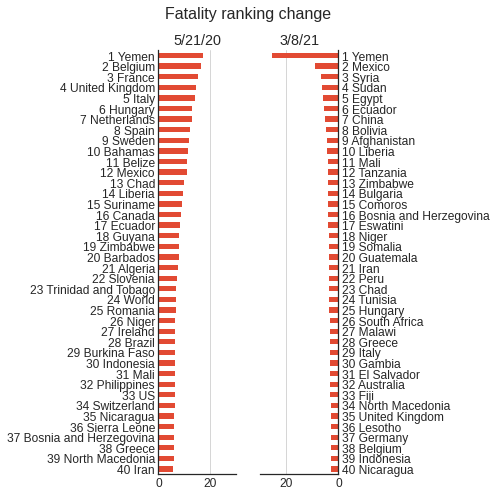

In [444]:
style.use('seaborn-white')

fig, ax = plt.subplots(1,2, figsize= (7,7))
fatspring[:40].plot.barh(ax=ax[0])
fatwinter[:40].plot.barh(ax= ax[1])
for n in range(2):
    ax[n].invert_yaxis()
    ax[n].legend('')
    ax[n].set_title('{}'.format(time[n]))
    ax[n].set_ylabel('')
    ax[n].set_xlim(0,30)
    ax[n].grid(axis='x')
    ax[n].spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].invert_xaxis()
ax[1].yaxis.set_ticks_position('right')

ax[0].tick_params(axis='y', labelsize= 12)
ax[0].tick_params(axis='x', labelsize= 12)
ax[1].tick_params(axis='x', labelsize= 12)
ax[1].tick_params(axis='y', labelsize= 12)


plt.suptitle('Fatality ranking change', fontsize=16)
plt.tight_layout()
plt.savefig('pic/fatality_rank.png', dpi=160, bbox_inches='tight')
plt.show()